In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import time

In [ ]:
## set random seeds
import numpy as np
np.random.seed(10)

In [28]:
epochs=100
batch_size = 1000
test_batch_size = 10000
lr = 0.1
momentum = 0.5
log_interval = 50

In [29]:
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Grayscale(num_output_channels=1),
                       transforms.ToTensor()
                   ])),
    batch_size = batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                    transforms.Grayscale(num_output_channels=1),
                    transforms.ToTensor()
                    ])),
    batch_size = test_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified


In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = F.dropout(x, training=self.training)
        return F.log_softmax(x, dim=1)

model = Net()
model.cuda()

Net(
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)

In [31]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [32]:
import numpy as np
train_losses=np.zeros(epochs)
train_accs=np.zeros(epochs)
test_losses=np.zeros(epochs)
test_accs=np.zeros(epochs)

def train(epochs):
    model.train()
    for epoch in range(1, epochs+1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                correct=0.0
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                train_acc= correct / batch_size
                train_loss=loss.data[0]
                print('Train Epoch: {} \tLoss: {:.6f}\tAccuracy:{:.4f}'.format(
                    epoch, train_loss, train_acc))
                test_loss, test_acc = test()
                train_losses[epoch-1] = train_loss
                train_accs[epoch-1] = train_acc
                test_losses[epoch-1] = test_loss
                test_accs[epoch-1] = test_acc

In [33]:
def test():
    model.eval()
    test_loss = 0
    correct = 0.0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        test_acc= correct / len(test_loader.dataset)

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_acc))
    return(test_loss, test_acc)

In [34]:
start_time = time.time()
train(epochs)
print("--- Training Time - %s seconds ---" % (time.time() - start_time))

Train Epoch: 1 	Loss: 2.305794	Accuracy:0.1010

Test set: Average loss: 2.3042, Accuracy: 969.0/10000 (0.0969%)

Train Epoch: 2 	Loss: 2.302336	Accuracy:0.0900

Test set: Average loss: 2.3020, Accuracy: 1039.0/10000 (0.1039%)

Train Epoch: 3 	Loss: 2.300783	Accuracy:0.1410

Test set: Average loss: 2.3009, Accuracy: 1051.0/10000 (0.1051%)

Train Epoch: 4 	Loss: 2.296061	Accuracy:0.1640

Test set: Average loss: 2.2966, Accuracy: 1428.0/10000 (0.1428%)

Train Epoch: 5 	Loss: 2.252367	Accuracy:0.1620

Test set: Average loss: 2.2507, Accuracy: 1783.0/10000 (0.1783%)

Train Epoch: 6 	Loss: 2.140454	Accuracy:0.2130

Test set: Average loss: 2.1650, Accuracy: 2040.0/10000 (0.2040%)

Train Epoch: 7 	Loss: 2.014831	Accuracy:0.2620

Test set: Average loss: 2.0249, Accuracy: 2699.0/10000 (0.2699%)

Train Epoch: 8 	Loss: 1.996113	Accuracy:0.2780

Test set: Average loss: 2.0559, Accuracy: 2317.0/10000 (0.2317%)

Train Epoch: 9 	Loss: 1.952708	Accuracy:0.2880

Test set: Average loss: 1.9474, Accuracy:


Test set: Average loss: 1.4807, Accuracy: 5474.0/10000 (0.5474%)

Train Epoch: 73 	Loss: 0.711679	Accuracy:0.7480

Test set: Average loss: 1.3980, Accuracy: 5630.0/10000 (0.5630%)

Train Epoch: 74 	Loss: 0.661279	Accuracy:0.7820

Test set: Average loss: 1.3866, Accuracy: 5721.0/10000 (0.5721%)

Train Epoch: 75 	Loss: 0.654456	Accuracy:0.7780

Test set: Average loss: 1.4016, Accuracy: 5668.0/10000 (0.5668%)

Train Epoch: 76 	Loss: 0.718605	Accuracy:0.7480

Test set: Average loss: 1.4371, Accuracy: 5588.0/10000 (0.5588%)

Train Epoch: 77 	Loss: 0.619930	Accuracy:0.7880

Test set: Average loss: 1.4294, Accuracy: 5675.0/10000 (0.5675%)

Train Epoch: 78 	Loss: 0.650370	Accuracy:0.7720

Test set: Average loss: 1.4685, Accuracy: 5587.0/10000 (0.5587%)

Train Epoch: 79 	Loss: 0.701731	Accuracy:0.7620

Test set: Average loss: 1.5273, Accuracy: 5472.0/10000 (0.5472%)

Train Epoch: 80 	Loss: 0.631484	Accuracy:0.7720

Test set: Average loss: 1.4831, Accuracy: 5625.0/10000 (0.5625%)

Train Epoch: 

Text(0.5,1,'Test Accuracy: 0.55')

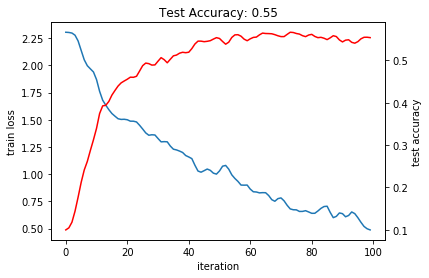

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

test_acc_smooth = gaussian_filter1d(test_accs, sigma=0.5)
train_loss_smooth = gaussian_filter1d(train_losses, sigma=1)
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(epochs), train_loss_smooth)
ax2.plot(range(len(test_acc_smooth)), test_acc_smooth, 'r')
ax1.set_xlabel('epoch')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_accs[-1]))